# Utilities

In [1]:
%gui wx
import os
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, DownloadProgressBar, download_url, direct_file_download_open_neuro, get_json_from_file
os.environ["DIPY_HOME"] = "./data/"
loadFSL()
import fsl.wrappers
from fsl.wrappers import fslmaths, mcflirt
import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri
import mne
import mne_nirs
import shutil
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob
import ants
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report
import requests
import urllib.request
from tqdm import tqdm
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt
import glob
import pandas as pd
import numpy as np
import json
import subprocess
import matplotlib.pyplot as plt
import os
import sys

sys.stderr = open(os.devnull, 'w')
os.environ['G_DEBUG'] = 'fatal-warnings'

In [2]:
%load_ext autoreload
%autoreload 2
from utilities import get_skull_stripped_anatomical, apply_python_mask_approach, launch_freeview, fsl_anat_wrapped, load_mot_params_fsl_6_dof, compute_FD_power, apply_transform, combine_all_transforms, normalize_fMRI

In [3]:
%%capture
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

# Folders

In [4]:
dataset_id = 'ds000171' 
subject_id = 'control01'    
sample_path = "./data/" 
os.makedirs(sample_path, exist_ok=True)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives') 
preproc_root = op.join(bids_root, 'derivatives', 'preprocessed_data') 
os.makedirs(bids_root, exist_ok=True)
subject_dir = 'sub-{}'.format(subject_id)

## Download

In [5]:
%%capture
subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, 
                "--target-dir", bids_root, 
                "--include", op.join(subject_dir, '*'),    
               ], check=False) 
os.makedirs(op.join(bids_root, 'derivatives'), exist_ok=True)
preproc_root = op.join(bids_root, 'derivatives', 'preprocessed_data') 
os.makedirs(op.join(preproc_root, subject_dir), exist_ok=True)
os.makedirs(op.join(preproc_root, subject_dir, 'anat'), exist_ok=True)
os.makedirs(op.join(preproc_root, subject_dir, 'func'), exist_ok=True)
os.makedirs(op.join(preproc_root, subject_dir, 'fmap'), exist_ok=True)


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds000171 …


📁 Traversing directories for ds000171 : 436 entities [00:37, 11.57 entities/s]


📥 Retrieving up to 15 files (5 concurrent downloads). 


sub-control01_T1w.nii.gz:   1%|▏         | 118k/8.77M [00:00<00:14, 611kB/s] 
sub-control01_task-music_run-2_events.tsv:   0%|          | 0.00/339 [00:00<?, ?B/s]
sub-control01_T1w.nii.gz:   2%|▏         | 186k/8.77M [00:00<00:13, 649kB/s]        
sub-control01_task-music_run-1_bold.nii.gz:   0%|          | 0.00/33.8M [00:00<?, ?B/s]

sub-control01_T1w.nii.gz:   4%|▍         | 391k/8.77M [00:00<00:07, 1.12MB/s]0<?, ?B/s]
sub-control01_task-music_run-1_bold.nii.gz:   0%|          | 24.5k/33.8M [00:00<02:58, 199kB/s]

sub-control01_task-music_run-3_bold.nii.gz:   0%|          | 32.6k/33.9M [00:00<02:20, 253kB/s]


sub-control01_T1w.nii.gz:   9%|▉         | 815k/8.77M [00:00<00:03, 2.13MB/s]0<?, ?B/s]
sub-control01_task-music_run-1_bold.nii.gz:   0%|          | 74.5k/33.8M [00:00<01:49, 322kB/s]

sub-control01_T1w.nii.gz:  15%|█▌        | 1.34M/8.77M [00:00<00:02, 3.27MB/s]0<01:47, 330kB/s]


sub-control01_task-music_run-2_bold.nii.gz:   0%|          | 32.6k/33.9M [00:00<03:04, 193kB/s]
s

✅ Finished downloading ds000171.
 
🧠 Please enjoy your brains.
 






sub-control01_task-nonmusic_run-4_bold.nii.gz:  99%|█████████▉| 33.5M/33.9M [00:32<00:00, 3.89MB/s]



sub-control01_task-nonmusic_run-4_bold.nii.gz: 100%|█████████▉| 33.9M/33.9M [00:32<00:00, 3.91MB/s]



                                                                                                   

In [5]:
%%capture
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz')) 

# Initial preprocessing

## Skull stripping

In [6]:
resulting_mask_path = op.join(preproc_root, subject_dir, 'anat', 'sub-{}_T1w_mask'.format(subject_id) ) 

In [7]:
get_skull_stripped_anatomical(bids_root, preproc_root, "control01", robust=True)

Done with BET.


In [8]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz'))
fsleyesDisplay.load(resulting_mask_path)

In [9]:
anatomical_path = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz')
betted_brain_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz') 
resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask.nii.gz') 

In [10]:
apply_python_mask_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [11]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

## Tissue segmentation

In [12]:
betted_brain_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w')

In [13]:
[os.remove(f) for f in glob.glob(op.join(preproc_root, 'sub-control01', 'anat', '*fast*'))]
segmentation_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_fast')
fast(imgs=[betted_brain_path], out=segmentation_path, n_classes=3);

The pve files correspond to our segmented tissues. We have exactly three files, because we set n_classes to 3 above:
```python
fast(..., n_classes=3)


Display colors
- pve_0 in <span style="color:red;">red</span>
- pve_1 in <span style="color:green;">green</span>
- pve_2 in <span style="color:blue;">blue</span>

In [14]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)
# CSF
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-control01', 'anat','*pve_0*'))[0])
# GM
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-control01', 'anat','*pve_1*'))[0])
# WM
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-control01', 'anat','*pve_2*'))[0])

fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'


# Coregistration MNI-T1

### Linear normalization

In [15]:
subject_id = 'control01' 
subject_anatomical = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-control01_T1w')
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))

target = subject_anatomical 
reference = mni_template 
result = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni'.format(subject_id))
anat_2_mni_trans = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni_lin.mat'.format(subject_id))

In [16]:
flirt(target, reference, out=result)
flirt(betted_brain_path, mni_template, out=result, omat = anat_2_mni_trans)


Final result: 
0.003341 0.005724 -1.116060 204.820462 
-0.933200 0.500882 0.006703 178.661677 
0.501569 1.049029 -0.003770 -149.723790 
0.000000 0.000000 0.000000 1.000000 



{}

In [17]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(reference) 
fsleyesDisplay.load(result)

In [18]:
possible_costs = ['mutualinfo', 'corratio', 'normcorr', 'normmi', 'leastsq', 'labeldiff']
costs_to_consider = ['leastsq', 'normcorr'] 
# FIXME: ISSUE WITH THE LEASTSQ COST RESULT

In [19]:
for c in costs_to_consider:
    flirt(target, reference, out=result + '_' + c, cost=c)


Final result: 
3.458371 1.648305 3.627273 -990.534765 
-2.861950 1.235282 4.578044 -54.943603 
0.433791 -5.372595 2.300280 588.875671 
0.000000 0.000000 0.000000 1.000000 


Final result: 
0.003107 0.005315 -1.116440 204.932830 
-0.935071 0.500262 0.007008 178.944986 
0.501467 1.049276 -0.004127 -149.788866 
0.000000 0.000000 0.000000 1.000000 



In [20]:
for c in costs_to_consider:
    fsleyesDisplay.load(result + '_' + c)

## Non linear normalization

*FNIRT does NOT expect the input data to be skull-stripped.*

In [21]:
moving_image = ants.image_read(target + '.nii.gz')
fixed_image = ants.image_read(reference + '.nii.gz')
warp_field_path = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni_SyN_warp.nii.gz'.format(subject_id))
resultAnts = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni_SyN.nii.gz'.format(subject_id))
transformation = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform='SyN')
warpedImage = ants.apply_transforms(fixed=fixed_image, moving=moving_image, transformlist=transformation['fwdtransforms'])
ants.image_write(warpedImage, resultAnts)

warp_field = ants.image_read(transformation['fwdtransforms'][0])
nifti_warp_field = nib.Nifti1Image(warp_field.numpy(), affine=nib.load(transformation['fwdtransforms'][0]).affine)
nib.save(nifti_warp_field, warp_field_path)


In [22]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(reference)
fsleyesDisplay.load(resultAnts)
fsleyesDisplay.load(warp_field_path)

# Volume removal


In [23]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-2_bold.nii.gz'))

### Field stabilization

Text(0, 0.5, 'Mean voxel intensity')

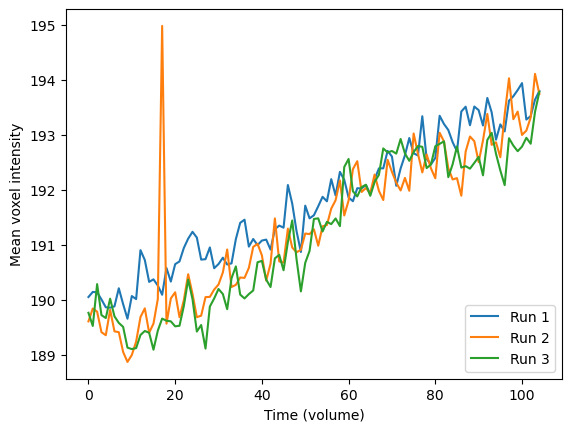

In [24]:
import matplotlib.pyplot as plt
import nibabel as nib
for run in range(1, 4):
    bold_path = op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-{}_bold.nii.gz'.format(run))
    bold_img = nib.load(bold_path)
    bold_data = bold_img.get_fdata()
    mean_data = bold_data.mean(axis=(0, 1, 2))
    plt.plot(mean_data, label='Run {}'.format(run))
plt.legend()
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

In [26]:
import matplotlib.pyplot as plt
import nibabel as nib
processed_functional_path = op.join(preproc_root, 'sub-control01', 'func')
functional_path = op.join(bids_root, 'sub-control01', 'func')

<h3>Correction of slice 17 in second run</h3>

In [27]:
path_normalized_output_1 = op.join(processed_functional_path, 'sub-control01_task-music_run-1_bold_norm.nii.gz')
path_normalized_output_2 = op.join(processed_functional_path, 'sub-control01_task-music_run-2_bold_norm_.nii.gz')
path_normalized_output_3 = op.join(processed_functional_path, 'sub-control01_task-music_run-3_bold_norm_.nii.gz')
functional_1_path = op.join(functional_path, 'sub-control01_task-music_run-1_bold.nii.gz')
functional_2_path = op.join(functional_path, 'sub-control01_task-music_run-2_bold.nii.gz')
functional_3_path = op.join(functional_path, 'sub-control01_task-music_run-3_bold.nii.gz')

In [28]:
img = nib.load(functional_2_path)
data = img.get_fdata()
data[:, :, 47, 17] = np.mean(data[:, :, 46, 17])
data = data[:, :, :, 1:]
img_out = nib.Nifti1Image(data,img.affine, img.header)
nib.save(img_out, op.join(functional_path, 'sub-control01_task-music_run-2_bold.nii.gz'))

Text(0, 0.5, 'Mean voxel intensity')

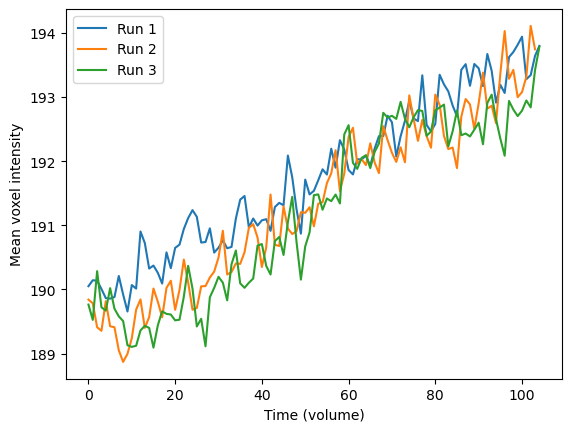

In [29]:
import matplotlib.pyplot as plt
import nibabel as nib
for run in range(1, 4):
    bold_path = op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-{}_bold.nii.gz'.format(run))
    bold_img = nib.load(bold_path)
    bold_data = bold_img.get_fdata()
    mean_data = bold_data.mean(axis=(0, 1, 2))
    plt.plot(mean_data, label='Run {}'.format(run))
plt.legend()
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

In [30]:
normalize_fMRI(functional_1_path, path_normalized_output_1, 200)
normalize_fMRI(functional_2_path, path_normalized_output_2, 200)
normalize_fMRI(functional_3_path, path_normalized_output_3, 200)

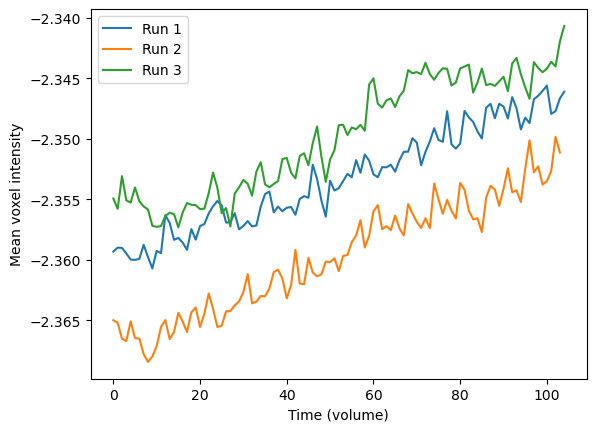

In [31]:
plt.plot(nib.load(path_normalized_output_1).get_fdata().mean(axis=(0,1,2)), label='Run 1')
plt.plot(nib.load(path_normalized_output_2).get_fdata().mean(axis=(0,1,2)), label='Run 2')
plt.plot(nib.load(path_normalized_output_3).get_fdata().mean(axis=(0,1,2)), label='Run 3')
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')
plt.legend()
plt.show()

In [32]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(functional_2_path)
fsleyesDisplay.load(path_normalized_output_2)

<h2>Concatenation of data</h2>

In [33]:
img_1 = nib.load(path_normalized_output_1)
data_1 = img_1.get_fdata()
img_2 = nib.load(path_normalized_output_2)
data_2 = img_2.get_fdata()
img_3 = nib.load(path_normalized_output_3)
data_3 = img_3.get_fdata()

In [34]:
img_1.shape, img_2.shape, img_3.shape

((80, 80, 50, 105), (80, 80, 50, 104), (80, 80, 50, 105))

In [35]:
data = np.concatenate((data_1, data_2, data_3), axis = 3)

In [36]:
functional_concatenated= op.join(functional_path, 'sub-control01_task-music_concat_bold.nii.gz')

In [37]:
img_out = nib.Nifti1Image(data,img_1.affine, img_1.header)
nib.save(img_out, functional_concatenated)

In [38]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(functional_concatenated)

## Motion correction

In [39]:
path_moco_data = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_moco.nii.gz')
mcflirt(
    infile=functional_concatenated,  # The input file (original BOLD data)
    o=path_moco_data,           # The output file (motion-corrected data)
    plots=True,                 # Generate plots for visualizing motion correction.
    report=True,                # Generate a report on the motion correction process.
    dof=6,                      # Set degrees of freedom to 6 for rigid-body transformation.
    mats=True                   # Save the transformation matrices.
)

In [40]:
fsleyesDisplay.resetOverlays() 
fsleyesDisplay.load(functional_concatenated)
fsleyesDisplay.load(path_moco_data) 

In [41]:
mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_moco.nii.gz.par')) 
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.002822,0.002768,0.000250,-0.068321,-0.539596,-0.540155
1,-0.003246,0.002395,0.000126,-0.086187,-0.514215,-0.557525
2,-0.002460,0.002727,0.000194,-0.066710,-0.480824,-0.535785
3,-0.002714,0.002677,0.000153,-0.074225,-0.495533,-0.550236
4,-0.002514,0.002576,0.000211,-0.088803,-0.499913,-0.568994
...,...,...,...,...,...,...
309,0.009593,-0.000060,-0.001486,-0.097600,0.373963,0.161444
310,0.010114,-0.000524,-0.001859,-0.098202,0.365516,0.147373
311,0.010016,-0.000606,-0.001797,-0.099236,0.375929,0.141203
312,0.010114,-0.001014,-0.001852,-0.102328,0.366555,0.131498


Based on **translation on X alone**, can you find perhaps a volume which exceeds with respect to the **preceding volume** a 0.2 mm displacement?

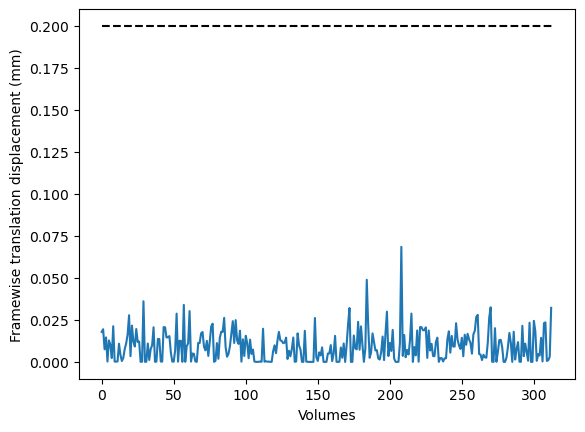

In [42]:
trans_x = mot_params["Translation x"] # Getting the translation on X
# Now, we want a 0.2mm with respect to previous frame:
disp_x = np.diff(trans_x) # Getting the displacement on X. We use np.diff to calculate the difference between consecutive elements in the translation on X.
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.2 
plt.plot(np.abs(disp_x))
plt.hlines(threshold, 0, len(disp_x),colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()

Now, we can use the code below to extract an aggregate measure of motion for all volumes. 

In [43]:
fd = compute_FD_power(mot_params).to_numpy()

In [44]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

In [45]:
import plotly.express as px

fig = px.line(x=list(range(1, fd.size+1)), y=fd, labels={'x': 'Volume', 'y': 'FD displacement (mm)'})
fig.add_hline(y=threshold, line_dash="dash", annotation_text="FD threshold", annotation_position="bottom right")
fig.show()

In [46]:
# Volume indices where FD is above the threshold
np.where(fd > threshold)[0] + 1 

array([ 71, 105, 209, 224, 228, 268, 269, 274])

In [47]:
#FIXME THERE ARE VOLUMES TO BE REMOVED

# Coregistration of functional to anatomical

In [5]:
from fsl.wrappers import epi_reg


epi_target = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_moco.nii.gz')
whole_t1 = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w')
skull_stripped_t1 = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w') 
output_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_moco_bbr')
ref_vol_name = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_moco_vol_middle') 

In [49]:
split_target = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_moco.nii.gz')
split_name = op.join(preproc_root, 'sub-control01', 'func', 'splits','sub-control01_task-music_concat_bold_moco_split')
subprocess.run(['fslsplit', split_target, split_name, '-t'])

CompletedProcess(args=['fslsplit', './data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat_bold_moco.nii.gz', './data/ds000171/derivatives/preprocessed_data/sub-control01/func/splits/sub-control01_task-music_concat_bold_moco_split', '-t'], returncode=-6)

In [50]:
use_single_vol = True

if use_single_vol:

    fslroi(epi_target, ref_vol_name, str(150), str(1))
    
    # Run epi_reg to register the extracted middle EPI volume to the T1-weighted anatomical image.
    subprocess.run([
        'epi_reg',
        '--epi={}'.format(ref_vol_name),  # The EPI image (middle volume) to be registered.
        '--t1={}'.format(whole_t1),       # The whole, non-skull-stripped T1-weighted image.
        '--t1brain={}'.format(skull_stripped_t1),  # The skull-stripped T1-weighted image.
        '--out={}'.format(output_path)    # The output path where the registered image will be saved.
    ])
else:
    # If not using a single volume, register the entire motion-corrected EPI series to the T1-weighted anatomical image.
    subprocess.run([
        'epi_reg',
        '--epi={}'.format(epi_target),    # The full motion-corrected EPI image (all volumes).
        '--t1={}'.format(whole_t1),       # The whole, non-skull-stripped T1-weighted image.
        '--t1brain={}'.format(skull_stripped_t1),  # The skull-stripped T1-weighted image.
        '--out={}'.format(output_path),    # The output path where the registered image will be saved.
    ])


Running FAST segmentation
FLIRT pre-alignment
Running BBR
0.253728 0.999301 -0.037346 -0.001768 0.000000 0.037357 0.999281 0.006432 0.000000 0.001527 -0.006493 0.999978 0.000000 -5.102015 8.856446 -0.825358 1.000000 


In [117]:
epi_target

'./data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat_bold_moco.nii.gz'

In [7]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(skull_stripped_t1)
fsleyesDisplay.load(epi_target)
fsleyesDisplay.load(output_path)
fsleyesDisplay.load(resultAnts)


In [6]:
warp_field_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_moco_bbr_warp.nii.gz')
resultAnts = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_moco_bbr_SyN.nii.gz')
moving_image = ants.image_read(output_path + '.nii.gz')
fixed_image = ants.image_read(whole_t1+".nii.gz")  # The T1-weighted anatomical image as the fixed reference

# Step 2: Use ANTs for finer SyN registration from EPI to T1
transformation = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform='SyN')
warpedImage = ants.apply_transforms(fixed=fixed_image, moving=moving_image, transformlist=transformation['fwdtransforms'])

# Save the refined output and transformation warp field
ants.image_write(warpedImage, resultAnts)

# Save the warp field as a NIfTI file for future reference
warp_field = ants.image_read(transformation['fwdtransforms'][0])
nifti_warp_field = nib.Nifti1Image(warp_field.numpy(), affine=nib.load(transformation['fwdtransforms'][0]).affine)
nib.save(nifti_warp_field, warp_field_path)



(ipykernel_launcher.py:268948): Gtk-WARNING **: 00:23:08.723: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:268948): Gtk-WARNING **: 00:23:08.723: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton)

(ipykernel_launcher.py:268948): Gtk-WARNING **: 00:23:08.723: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:268948): Gtk-WARNING **: 00:23:08.723: for_size smaller than min-size (1 < 16) while measuring gadget (node button, owner GtkSpinButton)

(ipykernel_launcher.py:268948): Gtk-WARNING **: 00:23:08.765: Negative content width -1 (allocation 1, extents 1x1) while allocating gadget (node spinbutton, owner GtkSpinButton)

(ipykernel_launcher.py:268948): Gtk-WARNING **: 00:23:08.765: for_size smaller than min-size (1 < 32) while measuring gadget (node entry, owner GtkSpinButton

In [108]:
# Convert the transformation matrix to a warp field
transform1 = '/home/nicolasrr/Desktop/NeuroDesk/NSSP/data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat_bold_moco.nii.gz.mat/MAT_0150'
transform2 = output_path+'.mat'
# Let's combine the different transforms EXCEPT motion correction!
warp_name_test = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_moco_bbr_test_warp.nii.gz')
subprocess.run([
    'convertwarp',
    '--ref={}'.format(mni_template),
    '--premat={}'.format(transform1),
    '--midmat={}'.format(transform2),
    '--postmat={}'.format(anat_2_mni_trans),
    '--out={}'.format(warp_name_test)
])    

CompletedProcess(args=['convertwarp', '--ref=/data/fsl//data/standard/MNI152_T1_1mm_brain', '--premat=/home/nicolasrr/Desktop/NeuroDesk/NSSP/data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat_bold_moco.nii.gz.mat/MAT_0150', '--midmat=./data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat_bold_moco_bbr.mat', '--postmat=./data/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_mni_lin.mat', '--out=./data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat_bold_moco_bbr_test_warp.nii.gz'], returncode=0)

In [67]:
from scipy.ndimage import affine_transform


transform_matrix = np.loadtxt(transform1)  # replace 'your_matrix_name' with the key in your .mat file

# Load the NIfTI image
nifti_img = nib.load(ref_vol_name+'.nii.gz')
nifti_data = nifti_img.get_fdata()
affine = nifti_img.affine

# Apply the transformation to the image data
# Adjust the inverse of the affine if necessary to account for the spatial orientation of the image
transformed_data = affine_transform(nifti_data, transform_matrix, offset=0)
transformed_img = nib.Nifti1Image(transformed_data, affine)
nib.save(transformed_img, 'test.nii.gz')

In [110]:
from fsl.wrappers import applywarp
out_vol = "test.nii.gz"
applywarp(ref_vol_name,mni_template, out_vol, w=warp_name_test, rel=False)

{}

Let's overlay the two (EPI and anatomical) on top of each other to visualize the quality of the coregistration!

In [111]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(mni_template)
# fsleyesDisplay.load(skull_stripped_t1)
# fsleyesDisplay.load(output_path)
# fsleyesDisplay.load(ref_vol_name)
fsleyesDisplay.load(out_vol)

- Is the functional in the right orientation?
- Are the ventricles correctly aligned?
- Are the boundaries of the EPI more or less matching the anatomical?

➡️ You can also check how the white matter of the EPI matches your anatomical's white matter provided you have sufficient resolution

#### Some cleanup
If you have a look, you might notice that perhaps your directory got filled with many files. These are temporary files, created but uncorrectly not eliminated by epi_reg. The following should help:


In [ ]:
def cleanup_epi_reg(path_to_clean):
    patterns = ['*_fast_*', '*_fieldmap*']
    for p in patterns:
        files = glob.glob(op.join(path_to_clean, p))
        for f in files:
            os.remove(f)

In [ ]:
cleanup_epi_reg(op.join(preproc_root, 'sub-control01', 'func'))

In [ ]:
print_dir_tree(bids_root, max_depth=5)

#### Smoothing

All these transforms are not exactly perfect. As you've seen in class, a step of smoothing is typically applied, with the size of the smoothing being dependent on your application, starting resolution etc.
The idea of smoothing is really that, as you're averaging, hopefully you increase the signal to noise ratio. <br>
A side-effect is that finest patterns of activation will be lost in the averaging (we can't have everything: there's no free lunch).

With FSL, smoothing is rather easy to do. However, one thing which is important is the size of your filter.
Different softwares might use different conventions. For MRI, it is typical to talk about FWHM (Full-width at half maximum), expressed in mms.

FSL, however, takes as input in sigma instead of FWHM. The conversion is easy fortunately:

$$ \sigma = \frac{FWHM}{2.3548}$$

Here for example would be the smoothing command for 6mm FWHM smoothing:

In [ ]:
# Define the path where the output will be saved (same as input).
# output_path = op.join(preproc_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold_bbr') # ....

cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
# This line constructs a command string using 'fslmaths' to apply spatial smoothing to the image.
# - 'fslmaths' is the FSL command used for mathematical manipulation of images.
# - '{}': Placeholder for 'output_path', which is the path to the image that needs smoothing.
# - '-s': This option applies a Gaussian kernel smoothing with a given standard deviation (sigma).
# - '6/2.3548': The value (6 mm divided by 2.3548) converts the full width at half maximum (FWHM) to sigma.
# - '{}_smoothed-6mm': This specifies the output file name, indicating that it has been smoothed with a 6 mm FWHM kernel.

subprocess.run(['fslmaths', output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])
# This line runs the 'fslmaths' command directly as a subprocess.
# - 'fslmaths': The command to manipulate the image.
# - 'output_path': The input file path of the image to be smoothed.
# - '-s': The option for applying Gaussian smoothing.
# - 'str(6/2.3548)': The sigma value calculated by converting the 6 mm FWHM value to standard deviation.
# - '{}_smoothed-6mm'.format(output_path)': The output path where the smoothed image will be saved, named with a suffix '_smoothed-6mm'.




In [ ]:
fsleyesDisplay.load(output_path + '_smoothed-6mm')

In [ ]:
cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(epi_target, 6/2.3548, epi_target)
# This line constructs a command string using 'fslmaths' to apply spatial smoothing to the image.
# - 'fslmaths' is the FSL command used for mathematical manipulation of images.
# - '{}': Placeholder for 'output_path', which is the path to the image that needs smoothing.
# - '-s': This option applies a Gaussian kernel smoothing with a given standard deviation (sigma).
# - '6/2.3548': The value (6 mm divided by 2.3548) converts the full width at half maximum (FWHM) to sigma.
# - '{}_smoothed-6mm': This specifies the output file name, indicating that it has been smoothed with a 6 mm FWHM kernel.

subprocess.run(['fslmaths', epi_target, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(epi_target.replace('.nii.gz', '')])

Let's observe what we have now:

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(epi_target + '_smoothed-6mm')

In [ ]:
import time
from fsl.wrappers import applywarp
ref=mni_template

# We show this one when selecting the first EPI (volume 0000)
target_epi = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_first-vol')
split_nbr = '0000'

# We will name its warp as split0000
warp_name = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_split' + split_nbr + '_epi_2_std_warp')

# Get the transformation matrix of this volume (this one is actually the unit matrix, 
# since this volume is the reference)


# -- Step 1: Combine the transformations, that is :
#    EPI -> Motion correction -> Coregistration to anatomical -> Normalization to standard
#    EPI -> Motion correction is given by the matrix in sub-control01_task-music_concat_bold_moco.mat/MAT_{vol_nbr}, where {vol_nbr} is the volume number of the volume of interest
#    EPI -> Coreg to anatomical, this is the _warp.nii.gz file in func/ folder
#    Anatomical > Template is saved by flirt when doing the anatomical to template coregistration, in anat/ folder
func_2_anat= op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_anat-space_warp.nii.gz')
epi_moco = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_moco.mat/', 'MAT_' + split_nbr)

s0 = time.time()
combine_all_transforms(ref, warp_name,  True, epi_2_moco=epi_moco, epi_2_anat_warp=func_2_anat, anat_2_standard_warp=anat_2_mni_trans)
s1 = time.time()

out_vol= op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_std_vol' + split_nbr)

# -- Step 2: Apply the transformation to our EPI
applywarp(target_epi,ref, out_vol, w=warp_name, rel=False)
s2 = time.time()

In [6]:
split_target =  './data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat_bold_smoothed-6mm.nii.gz'

In [ ]:
# We will split our starting EPI volume across time 
split_name = op.join(preproc_root, 'sub-control01', 'func', 'splits','sub-control01_task-music_concat_bold_bbr_smoothed-6mm_split')

subprocess.run(['fslsplit', split_target, split_name, '-t'])

Let's have a look at our folder structure now.

In [ ]:
print_dir_tree(bids_root,max_depth=5)

As you can see, a lot of new volumes have appeared. These are the split, individual volumes of our EPI.

Great, let's now combine the different transforms EXCEPT motion correction, with method 2.

In [ ]:
split_vols = sorted(glob.glob(op.join(preproc_root, 'sub-control01', 'func', 'splits','*split*')))
split_vols[0]

In [ ]:
warp_name = "/home/nicolasrr/Desktop/NeuroDesk/NSSP/data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat_bold_bbr.nii.gz"

nib.load(warp_name)

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(split_vols[0])
#nib.load(warp_name)

In [ ]:
from fsl.wrappers import applywarp
applywarp(split_vols[0],mni_template, "test.nii.gz", w=warp_name, rel=True)

In [ ]:
subprocess.run(['applywarp', '-i', split_vols[0], '-r', mni_template, '-o', "test.nii.gz", '-w', warp_name, '--abs'])

In [ ]:
import concurrent.futures
from tqdm import tqdm
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))


# Let's combine the different transforms EXCEPT motion correction!
warp_name = "/home/nicolasrr/Desktop/NeuroDesk/NSSP/data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat_bold_bbr.nii.gz"
split_vols = sorted(glob.glob(op.join(preproc_root, 'sub-control01', 'func', 'splits','*split*')))


# Define a function that wraps subprocess.run()
def run_subprocess(split_vol, vol_nbr):
    """
    SAFETY GOGGLES ON
    This function launches applywarp in parallel to reach complete result quicker

    Parameters
    -----------
    split_vol: str
        Path to the volume on which to apply the transformation
    vol_nbr: str
        Number of the volume in the timeserie. Useful to reorder volumes after the fact, since parallelisation does not honour order.

    Returns
    -------
    out_vol: str
        Path to the transformed volume
    vol_nbr: str
        Number of the volume in the timeserie. Useful to reorder volumes after the fact.
    """
    try:
        split_nbr = split_vol.split('_')[-1].split('.')[0].split('split')[1]
        out_vol= op.join(preproc_root, 'sub-control01', 'func', 'splits', 'sub-control01_task-music_concat_bold_bbr_smoothed-6mm_split' + split_nbr)
        result = subprocess.run(['applywarp', '-i', split_vol, '-r', mni_template, '-o', out_vol, '-w', warp_name, '--abs'])
        return out_vol, vol_nbr
    except subprocess.CalledProcessError as e:
        return f"applywarp for volume '{split_vol}' failed with error: {e.stderr.decode('utf-8')}"


produced_vols = [None]*len(split_vols)
# Initialize ThreadPoolExecutor and the progress bar
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use tqdm to wrap the futures
    with tqdm(total=len(split_vols)) as progress:
        # Launch subprocesses in parallel
        futures = {executor.submit(run_subprocess, vol,i): vol for i,vol in enumerate(split_vols)}

        # Process completed tasks
        for future in concurrent.futures.as_completed(futures):
            out_vol, vol_nbr = future.result()  # Get the result of the subprocess
            produced_vols[vol_nbr] = out_vol
            # Update the progress bar for each completed task
            progress.update(1)
            break

Why does it matter? Well, just applying a back-of the envelope calculation, the first method takes 122s per volume, while the second method takes 87 seconds to combine **once** the transforms excluding motion correction, and 4 seconds per volume to apply the transforms including motion correction. If we plot the two with an increasing number of volumes, we can see why this quickly becomes relevant:

## Slice correction 

#### Application to real data

We have shown you the basic principle, but the application to real data requires some specific informations.
You need the following ingredients:
- When was each slice acquired in the sequence: **(Slice timing)**
- Along which axis were the slices acquired: **Phase direction**
- How much time we take to acquire all slices: **TR**


In [ ]:
data = get_json_from_file(op.join(bids_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold.json'))
data

This data is actually a dictionary. We can thus extract the slice timing as an array directly from it. For example, to extract TaskName, we would use:
```python
data['TaskName']
```



In [ ]:
slice_timing = data['SliceTiming'] # Replace with the appropriate key (have a look above!)

Now, we might want to know where our slices are, ie along which axis, right? Typically it is along the z-direction, but we're better off if we check! Using FSLeyes, determine how many slices each axis has **for the functional data of interest**. You should thus open the relevant functional file in FSLeyes to answer this question.


<div class="warning" style='background-color:#90EE90; color: #112A46; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:center'><b>Using FSL command line</b></p>
<p style='text-indent: 10px;'>To figure out the dimensions of an MRI image, a faster option - if you have FSL installed directly - is to run the command line command:
    <blockquote>fslhd [your_volume]</blockquote>
This will give you all informations contained within the header of the NIfti file. For example, running the command for our volume will easily allow us to access the slice informations:
    <img src="imgs/fslhd_capture.png"></p>
</span>
</div>
Let's compare now with the amount of slices we have in our acquisition. We can consider simply the number of timings for this

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold.nii.gz'))

In [ ]:
len(slice_timing)

Great, so we know which axis we want, we know the slice timings, but we still need to know the TR. This information is also in the JSON sidecar! Extract it now!

In [ ]:
tr = data['RepetitionTime'] # Extract the TR from the sidecar's appropriate field
tr

To now perform the correction, we need to apply FSL's slicetimer command. For this, we need to save the timings first to their own separate file! Instead of giving the slice timings, we will provide instead the slice **order** (ie which slice was done in which order) and let FSL figure out how to best correct based on this information.

Let's do it.

In [ ]:
slice_order = np.argsort(slice_timing) + 1

# Write to a file the corresponding sorted timings :)
timing_path = op.join(preproc_root,  'sub-001', 'func', 'sub-001_task-sitrep_run-01_slice-timings.txt')
file = open(timing_path, mode='w')
for t in slice_order:
    file.write(str(t) + '\n')
file.close()

Finally we can call slicetimer from a terminal!

In [ ]:
file_to_realign = op.join(bids_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold')
output_target = op.join(preproc_root, 'sub-001', 'func', 'sub-001_task-sitrep_run-01_bold_slice-corr')

subprocess.run(['slicetimer', '-i', file_to_realign, '-o', output_target, '-r', str(tr), '-d', str(3), '--ocustom={}'.format(timing_path)])
#cmd = 'slicetimer -i ' + file_to_realign + ' -o ' + output_target + ' -r ' + str(tr) + ' -d 3 --ocustom=' + timing_path
#os.system(cmd)

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(file_to_realign)
fsleyesDisplay.load(output_target)